In [49]:
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
from langgraph.graph import StateGraph, END, START, add_messages
from typing import TypedDict, Annotated
from langchain_core.messages import HumanMessage, BaseMessage
from langgraph.checkpoint.memory import MemorySaver

In [50]:
load_dotenv()
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash")

In [51]:
class ChatbotState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [52]:
def chatnode(state: ChatbotState):

    messages = state["messages"]
    response = llm.invoke(messages)
    return {"messages": [response]}

In [54]:
checkpointer = MemorySaver()
graph = StateGraph(ChatbotState)

graph.add_node("chatnode",chatnode)

graph.add_edge(START, "chatnode")
graph.add_edge("chatnode",END)

workflow = graph.compile(checkpointer=checkpointer)

In [55]:
thread_id = "1"
while True:

    question = input("Ask me:")
    print("Me:",question)
    if question.lower().strip() in ["quit","exit"]:
        print("Ending, the chat.....")
        break
    else:
        config = {"configurable": {"thread_id": thread_id}}
        reaponse = workflow.invoke({"messages": [HumanMessage(content=question)]}, config=config)
        print("AI:",reaponse["messages"][-1].content)

Me: hii
AI: Hi there! How can I help you today?
Me: my name is bantee sharma what is your name
AI: It's nice to meet you, Bantee Sharma!

I don't have a name like a person does. I am a large language model, trained by Google. You can just call me a language model or an AI.
Me: okay, add 10 an 5
AI: 10 + 5 = 15
Me: can you talk to me, taking my name
AI: Certainly, Bantee Sharma! I can definitely do that.

So, how can I assist you further today, Bantee Sharma?
Me: if i want change my name so what name sholud i took
AI: That's a really personal and exciting decision, Bantee Sharma! The best name for you is one that truly resonates with *you* and makes you feel good.

I can't tell you *what* name you *should* take, because it's such a personal choice, but I can certainly help you think through the process and brainstorm ideas!

To help you decide, consider these questions:

1.  **What kind of feeling or meaning do you want your new name to convey?** (e.g., strong, peaceful, joyful, unique,

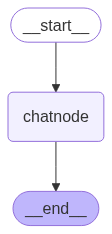

In [11]:
workflow